# DQN

In [24]:
import gym
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl

np.set_printoptions(suppress=True) 

In [25]:
#カートの描画処理

%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2 
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()    
    
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=50):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space   : Box(4,)
action space        : Discrete(2)
initial observation : [ 0.00694435 -0.03822883 -0.00707979 -0.03652975]
next observation    : [ 0.00617977 -0.23324854 -0.00781038  0.25391105]
reward              : 1.0
done                : False
info                : {}


<IPython.core.display.Javascript object>


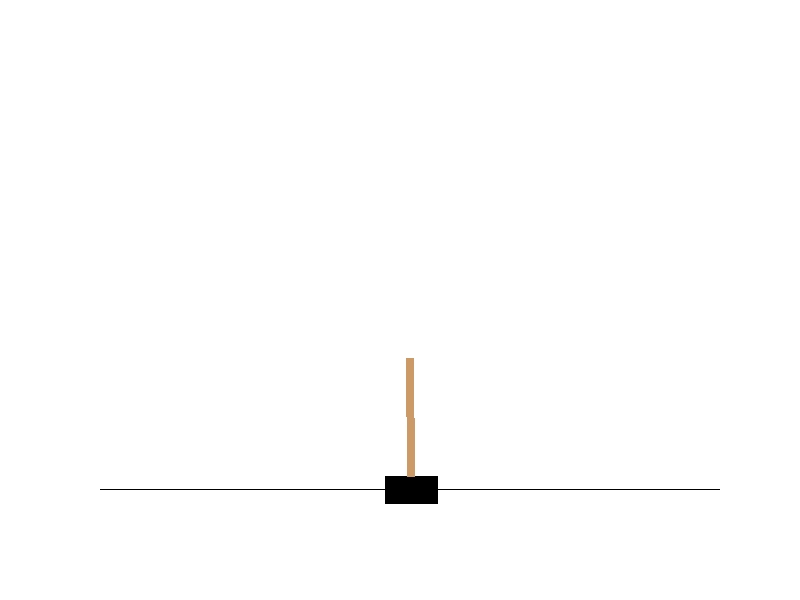

In [26]:
# 環境の読込と初期化
env = gym.make("CartPole-v0")
obs = env.reset() 
print("observation space   : {}".format(env.observation_space)) # 環境の状態 [position(カート位置), velocity(カート速度), angle(棒角度:0が垂直、0以上は右の傾き), angular_velocity(棒角速度)]
print("action space        : {}".format(env.action_space))      # 取りうる行動の選択肢の数(カートを右または左に動かすためDiscreteは「2」となる.左:0、右:1)
print("initial observation : {}".format(obs))  # 環境の状態

action = env.action_space.sample()
obs, r, done, info = env.step(action)

print('next observation    : {}'.format(obs))  # 次の状態
print('reward              : {}'.format(r))    # 現在の報酬 (棒の角度が20.9度以内かつ線の範囲内であれば1、それ以外は0)
print('done                : {}'.format(done)) # 終了状態かどうか
print('info                : {}'.format(info)) # デバック用の情報

# カート位置 -2.4～2.4
# カート速度 -3.0～3.0
# 棒角度 　  -41.8～41.8
# 棒角速度　 -2.0～2.0
# 終了状態   棒が20.9度以上傾くorカート位置が±2.4以上移動or定義されたエピソードを超過した場合

plot_cart_pole(env, obs)

In [31]:
# NNの定義
class QFunction(chainer.Chain):
    def __init__(self, obs_size, n_actions, n_hidden_channels=50):
        super().__init__(
            l0=L.Linear(obs_size, n_hidden_channels),
            l1=L.Linear(n_hidden_channels,n_hidden_channels),
            l2=L.Linear(n_hidden_channels, n_actions))
        
    def __call__(self, x, test=False): 
        h = F.tanh(self.l0(x)) 
        h = F.tanh(self.l1(h))
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)

In [34]:
# 学習関連のパラメータ
optimizer = chainer.optimizers.Adam(eps=1e-2)
#optimizer = chainer.optimizers.Adam()

optimizer.setup(q_func) 
gamma = 0.95
explorer = chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample)
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity = 10**6)
phi = lambda x:x.astype(np.float32, copy=False)

agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer, replay_start_size=500, phi=phi)

In [35]:
## 学習の開始: 10エピソード分

frames = []
avg =[]

n_episodes = 10 #
max_episode_len = 100 #最大ステップ数(成功とみなす回数)
#start = time.time()
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  
    t = 0
    act = []   
    
    #ステータスが"done"または100ステップ達成するまで繰り返し
    while not done and t < max_episode_len:
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
                
        img = render_cart_pole(env, obs)
        frames.append(img)
        act.append(action)
        
    agent.stop_episode_and_train(obs, reward, done)

    print ("ep",i,"step ",t, act)
    avg.append(t)

print ("avg step:",sum(avg)/len(avg), "total step:",sum(avg))

ep 1 step  12 [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
ep 2 step  8 [1, 1, 1, 1, 1, 1, 0, 1]
ep 3 step  9 [1, 1, 1, 1, 1, 1, 1, 1, 0]
ep 4 step  8 [1, 1, 1, 1, 1, 1, 1, 1]
ep 5 step  12 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]
ep 6 step  11 [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]
ep 7 step  9 [0, 0, 0, 0, 0, 0, 0, 0, 0]
ep 8 step  10 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ep 9 step  11 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
ep 10 step  9 [1, 1, 1, 1, 1, 1, 1, 1, 1]
avg step: 9.9 total step: 99


<IPython.core.display.Javascript object>


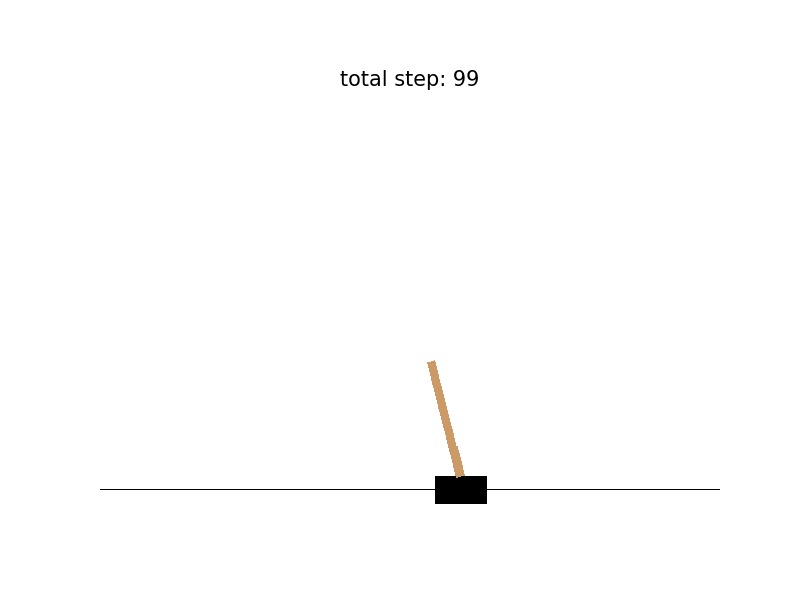

Text(0.5,1,'total step: 99')

In [37]:
video = plot_animation(frames)
plt.title('total step: {}'.format(sum(avg)))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
test episode: 0 R: 112.0
test episode: 1 R: 107.0
test episode: 2 R: 117.0
test episode: 3 R: 97.0
test episode: 4 R: 105.0
test episode: 5 R: 101.0
test episode: 6 R: 104.0
test episode: 7 R: 109.0
test episode: 8 R: 102.0
test episode: 9 R: 109.0
avg step: 106.3 total step: 1063


<IPython.core.display.Javascript object>


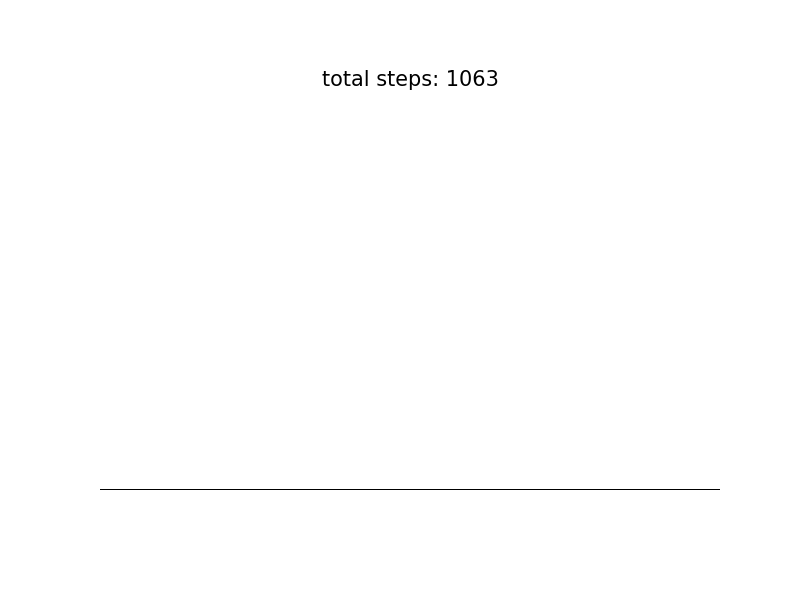

Text(0.5,1,'total steps: 1063')

In [38]:
# Test


agent.load('chainer_log/CartPole')
frames = []
ttlR = []
episode = 10

for i in range(episode):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    
    while not done and t < 200:

        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        ttlR.append(R)
        
        img = render_cart_pole(env, obs)
        frames.append(img)
        
    print('test episode:', i, 'R:', R)
    agent.stop_episode()
    
    
print ("avg step:",len(ttlR)/episode, "total step:",len(ttlR))

video = plot_animation(frames)
plt.title('total steps: {}'.format(len(ttlR)))

In [40]:
#=------------------------------------------------------
## 学習の開始: 500エピソード分



frames = []
avg =[]

n_episodes = 50 #
max_episode_len = 200 #最大ステップ数(成功とみなす回数)
#start = time.time()
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  
    t = 0
    #act = []   
    
    #ステータスが"done"または100ステップ達成するまで繰り返し
    while not done and t < max_episode_len:
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
                
        #img = render_cart_pole(env, obs)
        #frames.append(img)
        #act.append(action)

        
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
        agent.save('chainer_log/CartPole')
        
    agent.stop_episode_and_train(obs, reward, done)

    #print ("ep",i,"step ",t, )
    #print ("ep",i,"step ",t, act)
    avg.append(t)

print ("avg step:",sum(avg)/len(avg), "total step:",sum(avg))


episode: 10 R: 101.0 statistics: [('average_q', 4.074227208517117), ('average_loss', 0.026061847724573782)]
episode: 20 R: 15.0 statistics: [('average_q', 4.113055498456888), ('average_loss', 0.03086536089527703)]
episode: 30 R: 74.0 statistics: [('average_q', 4.142938300132072), ('average_loss', 0.02791989968583935)]
episode: 40 R: 14.0 statistics: [('average_q', 4.157106553488562), ('average_loss', 0.02336882247417544)]
episode: 50 R: 24.0 statistics: [('average_q', 4.152704355293437), ('average_loss', 0.02869298655076294)]
avg step: 69.44 total step: 3472


In [41]:
agent.save('chainer_log/CartPole')